# Data Loading

In [2]:
# ==========================================
# 1. DOWNLOAD & EXTRACT IBSR DATA
# ==========================================
!pip install -q gdown

import os
import glob
import gdown

# Google Drive file ID from assignment link
file_id = '1Q37u5v3a01I7n_B0iFbFeZoVipvK4ccq'
zip_name = 'IBSR_nifti_stripped.zip'
dst_root = './IBSR_dataset'

if not os.path.exists(zip_name):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, zip_name, quiet=False)
else:
    print(f"{zip_name} already exists, skipping download.")

if not os.path.exists(dst_root):
    os.makedirs(dst_root, exist_ok=True)
    !unzip -q "{zip_name}" -d "{dst_root}"
else:
    print(f"{dst_root} already exists, skipping unzip.")

# ==========================================
# 2. FIND VOLUMES & SEGMENTATIONS
# ==========================================
import re

# Recursively search for all nifti files
all_vols = sorted(glob.glob(os.path.join(dst_root, '**', '*_ana_strip.nii.gz'), recursive=True))
all_segs = sorted(glob.glob(os.path.join(dst_root, '**', '*_segTRI_fill_ana.nii.gz'), recursive=True))

print(f"Found {len(all_vols)} ana_strip (volume) files.")
print(f"Found {len(all_segs)} segTRI_fill_ana (label) files.")

print("\nSample volume paths:")
for p in all_vols[:3]:
    print("  ", p)
print("\nSample segmentation paths:")
for p in all_segs[:3]:
    print("  ", p)

def get_patient_id(path):
    base = os.path.basename(path)
    m = re.match(r'(IBSR_[0-9]+)', base)
    return m.group(1) if m else None

vol_dict = {}
for p in all_vols:
    pid = get_patient_id(p)
    if pid is not None:
        vol_dict[pid] = p

seg_dict = {}
for p in all_segs:
    pid = get_patient_id(p)
    if pid is not None:
        seg_dict[pid] = p

common_ids = sorted(set(vol_dict.keys()) & set(seg_dict.keys()))
print(f"\nSubjects with BOTH volume and segmentation: {len(common_ids)}")
print("Patient IDs:", common_ids)

vol_files = [vol_dict[pid] for pid in common_ids]
seg_files = [seg_dict[pid] for pid in common_ids]

# ==========================================
# 3. TRAIN / VALIDATION SPLIT (12/6)
# ==========================================
from math import floor

num_subjects = len(vol_files)
split_idx = floor(0.67 * num_subjects)

train_vol_files = vol_files[:split_idx]
train_seg_files = seg_files[:split_idx]
val_vol_files   = vol_files[split_idx:]
val_seg_files   = seg_files[split_idx:]

print(f"\nTotal subjects: {num_subjects}")
print(f"Train subjects: {len(train_vol_files)}")
print(f"Val subjects:   {len(val_vol_files)}")

for v, s in zip(train_vol_files, train_seg_files):
    print("TRAIN pair:", os.path.basename(v), "|", os.path.basename(s))
    break  

for v, s in zip(val_vol_files, val_seg_files):
    print("VAL pair:", os.path.basename(v), "|", os.path.basename(s))
    break  


IBSR_nifti_stripped.zip already exists, skipping download.
./IBSR_dataset already exists, skipping unzip.
Found 18 ana_strip (volume) files.
Found 18 segTRI_fill_ana (label) files.

Sample volume paths:
   ./IBSR_dataset/IBSR_nifti_stripped/IBSR_01/IBSR_01_ana_strip.nii.gz
   ./IBSR_dataset/IBSR_nifti_stripped/IBSR_02/IBSR_02_ana_strip.nii.gz
   ./IBSR_dataset/IBSR_nifti_stripped/IBSR_03/IBSR_03_ana_strip.nii.gz

Sample segmentation paths:
   ./IBSR_dataset/IBSR_nifti_stripped/IBSR_01/IBSR_01_segTRI_fill_ana.nii.gz
   ./IBSR_dataset/IBSR_nifti_stripped/IBSR_02/IBSR_02_segTRI_fill_ana.nii.gz
   ./IBSR_dataset/IBSR_nifti_stripped/IBSR_03/IBSR_03_segTRI_fill_ana.nii.gz

Subjects with BOTH volume and segmentation: 18
Patient IDs: ['IBSR_01', 'IBSR_02', 'IBSR_03', 'IBSR_04', 'IBSR_05', 'IBSR_06', 'IBSR_07', 'IBSR_08', 'IBSR_09', 'IBSR_10', 'IBSR_11', 'IBSR_12', 'IBSR_13', 'IBSR_14', 'IBSR_15', 'IBSR_16', 'IBSR_17', 'IBSR_18']

Total subjects: 18
Train subjects: 12
Val subjects:   6
TRAIN pa

# DataPrep Code

In [3]:
import numpy as np
import nibabel as nib
import warnings
import copy
import torch
from torch.utils.data import Dataset

def get_slice_data(volume_data, seg_data, axis, slice_idx):
    
    if axis == 0:  
        vol_slice = volume_data[slice_idx, :, :]
        seg_slice = seg_data[slice_idx, :, :]
    elif axis == 1:  
        vol_slice = volume_data[:, slice_idx, :]
        seg_slice = seg_data[:, slice_idx, :]
    else:  
        vol_slice = volume_data[:, :, slice_idx]
        seg_slice = seg_data[:, :, slice_idx]
    
    vol_slice = np.squeeze(vol_slice)
    seg_slice = np.squeeze(seg_slice)
    
    vol_slice_rotated = np.rot90(vol_slice, k=1)
    seg_slice_rotated = np.rot90(seg_slice, k=1)
    
    return vol_slice_rotated, seg_slice_rotated

def pad_slice(vol_slice, seg_slice, target_dims=(256, 256)):
    
    h, w = vol_slice.shape
    th, tw = target_dims

    pad_h_top = (th - h) // 2
    pad_h_bottom = th - h - pad_h_top
    pad_w_left = (tw - w) // 2
    pad_w_right = tw - w - pad_w_left

    padding = ((max(0, pad_h_top), max(0, pad_h_bottom)), 
               (max(0, pad_w_left), max(0, pad_w_right)))

    vol_padded = np.pad(vol_slice, padding, mode='constant', constant_values=0)
    seg_padded = np.pad(seg_slice, padding, mode='constant', constant_values=0)
    
    vol_padded = vol_padded[:th, :tw]
    seg_padded = seg_padded[:th, :tw]

    return vol_padded, seg_padded

class IBSRPatchDataset(Dataset):
    
    
    def __init__(self, volume_files, segmentation_files):
        self.patches = []
        self.masks = []
        self.patch_size = 128
        self.target_dims = (256, 256)
        self.slice_start = 10
        self.slice_stride = 3
        self.num_slices_to_extract = 48

        print("Loading and processing dataset (with rotation)...")
        for vol_path, seg_path in zip(volume_files, segmentation_files):
            try:
                vol_img = nib.load(vol_path)
                seg_img = nib.load(seg_path)

                vol_data = vol_img.get_fdata()
                seg_data = seg_img.get_fdata()

                for axis in range(3):
                    num_slices_in_axis = vol_data.shape[axis]
                    
                    slice_indices = list(range(
                        self.slice_start, 
                        num_slices_in_axis, 
                        self.slice_stride
                    ))[:self.num_slices_to_extract]

                    for slice_idx in slice_indices:
                        vol_slice_rotated, seg_slice_rotated = get_slice_data(vol_data, seg_data, axis, slice_idx)
                        
                        vol_padded, seg_padded = pad_slice(vol_slice_rotated, seg_slice_rotated, self.target_dims)
                        
                        for x in [0, self.patch_size]:
                            for y in [0, self.patch_size]:
                                vol_patch = vol_padded[x : x + self.patch_size, y : y + self.patch_size]
                                seg_patch = seg_padded[x : x + self.patch_size, y : y + self.patch_size]
                                
                                self.patches.append(vol_patch)
                                self.masks.append(seg_patch)
            except Exception as e:
                warnings.warn(f"Warning: Skipping file {vol_path} due to error: {e}")

        print(f"Dataset loaded. Total patches: {len(self.patches)}")

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        vol_patch = self.patches[idx].astype(np.float32)
        seg_patch = self.masks[idx].astype(np.int64)
        
        vol_patch_normalized = vol_patch

        
        vol_tensor = torch.tensor(vol_patch_normalized, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(seg_patch, dtype=torch.long) 
        
        return vol_tensor, mask_tensor


# Data Loader

In [4]:
from torch.utils.data import DataLoader

train_dataset = IBSRPatchDataset(train_vol_files, train_seg_files)
val_dataset   = IBSRPatchDataset(val_vol_files,   val_seg_files)

BATCH_SIZE = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)  
print("Mask batch shape: ", masks.shape)   


Loading and processing dataset (with rotation)...
Dataset loaded. Total patches: 6528
Loading and processing dataset (with rotation)...
Dataset loaded. Total patches: 3264
Image batch shape: torch.Size([1, 1, 128, 128])
Mask batch shape:  torch.Size([1, 128, 128])


In [5]:
import numpy as np

print("Checking a few random patches...")
for idx in [10, 50, 100, 500, 1000]:
    if idx >= len(train_dataset):
        break
    vol_tensor, mask_tensor = train_dataset[idx]
    vol_np = vol_tensor.squeeze().numpy()
    mask_np = mask_tensor.numpy()
    print(f"\nPatch index: {idx}")
    print("  vol min/max:", float(vol_np.min()), float(vol_np.max()))
    print("  seg unique:", np.unique(mask_np))


Checking a few random patches...

Patch index: 10
  vol min/max: 0.0 0.0
  seg unique: [0]

Patch index: 50
  vol min/max: 0.0 0.0
  seg unique: [0]

Patch index: 100
  vol min/max: 0.0 123.0
  seg unique: [0 1 2 3]

Patch index: 500
  vol min/max: 0.0 123.0
  seg unique: [0 1 2 3]

Patch index: 1000
  vol min/max: 0.0 110.0
  seg unique: [0 1 2]


# Visualize Patients Samples

Selected patient indices (train set): [9, 1, 8]

Patient: IBSR_10_ana_strip.nii.gz


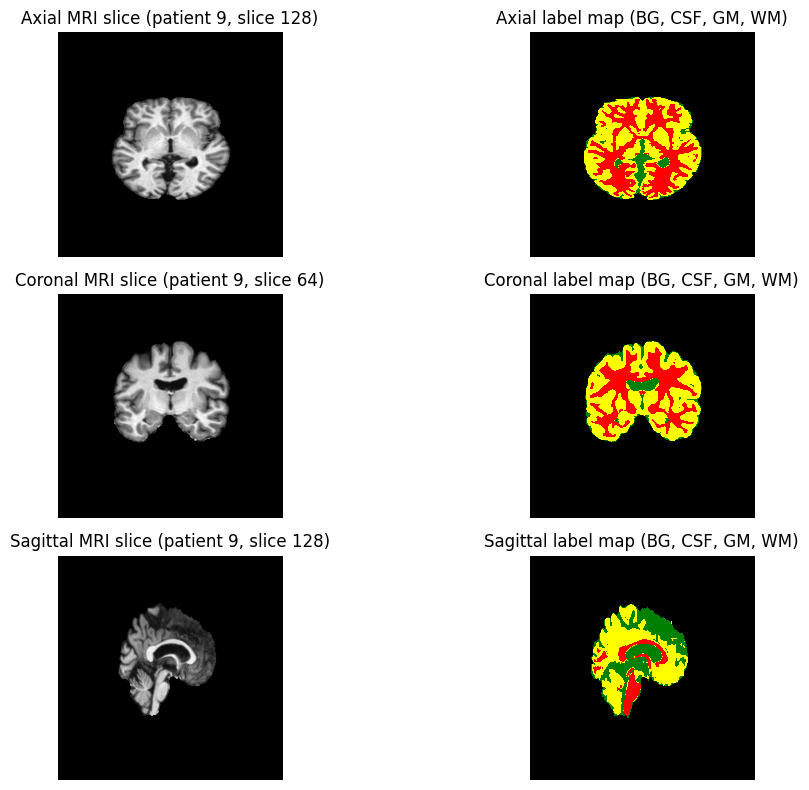


Patient: IBSR_02_ana_strip.nii.gz


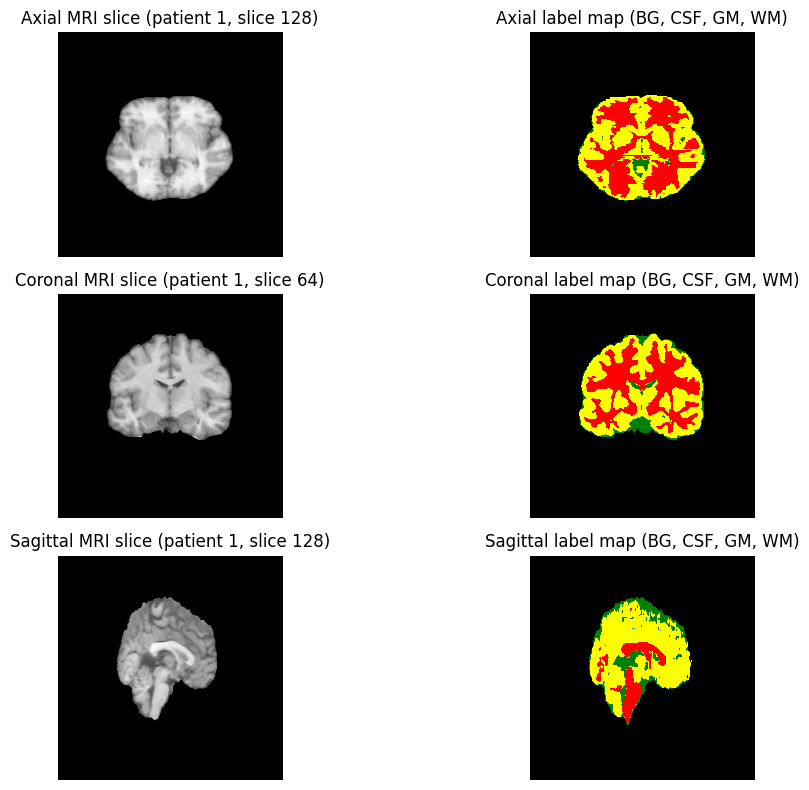


Patient: IBSR_09_ana_strip.nii.gz


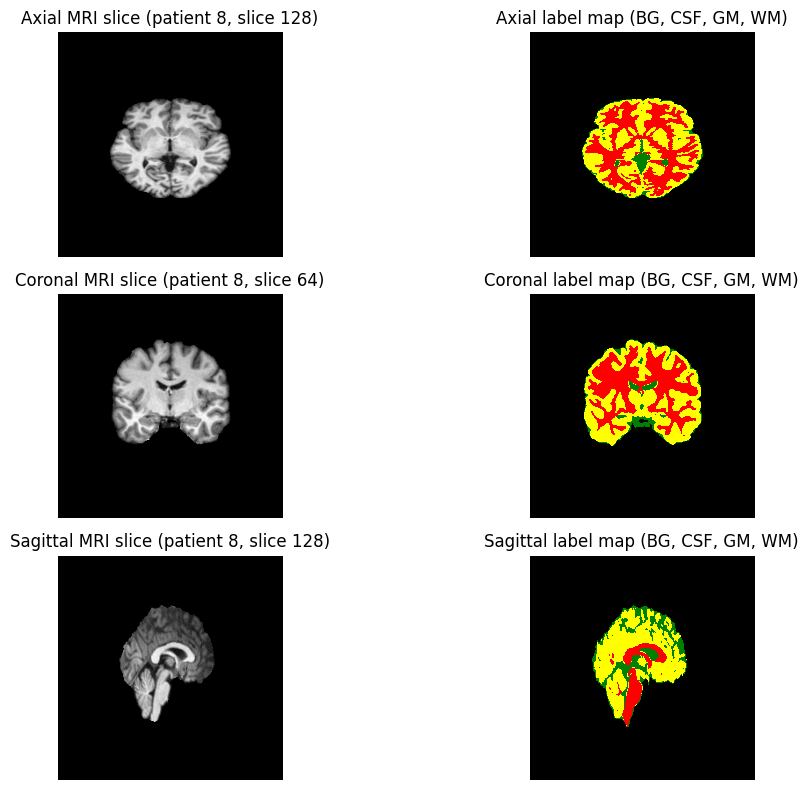

In [6]:
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

tissue_cmap = ListedColormap(['black', 'green', 'yellow', 'red'])

def visualize_3_patients_slices(volume_files, segmentation_files, num_patients=3):
    patient_indices = random.sample(range(len(volume_files)), num_patients)
    print("Selected patient indices (train set):", patient_indices)

    for p_idx in patient_indices:
        vol_path = volume_files[p_idx]
        seg_path = segmentation_files[p_idx]
        print("\nPatient:", os.path.basename(vol_path))

        vol_img = nib.load(vol_path)
        seg_img = nib.load(seg_path)
        vol_data = vol_img.get_fdata()
        seg_data = seg_img.get_fdata()

        # Handle possible 4D shape: squeeze singleton axis
        vol_data = np.squeeze(vol_data)
        seg_data = np.squeeze(seg_data)

        if vol_data.ndim != 3:
            print("Unexpected volume ndim:", vol_data.ndim, "shape:", vol_data.shape)
            continue

        x, y, z = vol_data.shape   # now guaranteed 3D

        slice_indices = {
            0: x // 2,  # sagittal
            1: y // 2,  # coronal
            2: z // 2   # axial
        }

        plt.figure(figsize=(12, 8))
        plot_idx = 1

        # Show axial, coronal, sagittal
        for axis in [2, 1, 0]:
            s_idx = slice_indices[axis]
            vol_slice_rot, seg_slice_rot = get_slice_data(vol_data, seg_data, axis, s_idx)
            vol_padded, seg_padded = pad_slice(vol_slice_rot, seg_slice_rot, target_dims=(256, 256))

            if axis == 2:
                plane_name = 'Axial'
            elif axis == 1:
                plane_name = 'Coronal'
            else:
                plane_name = 'Sagittal'

            # MRI
            plt.subplot(3, 2, plot_idx)
            plt.imshow(vol_padded, cmap='gray')
            plt.title(f'{plane_name} MRI slice (patient {p_idx}, slice {s_idx})')
            plt.axis('off')
            plot_idx += 1

            # Label map
            plt.subplot(3, 2, plot_idx)
            plt.imshow(seg_padded, cmap=tissue_cmap, vmin=0, vmax=3)
            plt.title(f'{plane_name} label map (BG, CSF, GM, WM)')
            plt.axis('off')
            plot_idx += 1

        plt.tight_layout()
        plt.show()

visualize_3_patients_slices(train_vol_files, train_seg_files, num_patients=3)


## Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=4):
        super(MNet, self).__init__()
        
        # --- Filters configuration (Doubling at each stage) ---
        filters = [32, 64, 128, 256]

        # --- LEFT LEG (Input Pyramid) ---
        # We use MaxPool to downsample the input image for multi-scale injection
        self.pool = nn.MaxPool2d(2, 2)

        # --- ENCODER (1x1 Convolutions as per paper) ---
        # Paper: "We use 1x1 convolutional kernels in the encoder module"
        
        # Stage 1
        self.enc1_1 = nn.Conv2d(in_channels, filters[0], kernel_size=1, padding=0)
        self.enc1_2 = nn.Conv2d(filters[0], filters[0], kernel_size=1, padding=0)
        
        # Stage 2 (Input: Pool1 + Downsampled Image Scale 2)
        # Input channels = filters[0] (from prev stage) + in_channels (from Left Leg)
        self.enc2_1 = nn.Conv2d(filters[0] + in_channels, filters[1], kernel_size=1, padding=0)
        self.enc2_2 = nn.Conv2d(filters[1], filters[1], kernel_size=1, padding=0)
        
        # Stage 3 (Input: Pool2 + Downsampled Image Scale 3)
        self.enc3_1 = nn.Conv2d(filters[1] + in_channels, filters[2], kernel_size=1, padding=0)
        self.enc3_2 = nn.Conv2d(filters[2], filters[2], kernel_size=1, padding=0)
        
        # Stage 4 (Bottleneck) (Input: Pool3 + Downsampled Image Scale 4)
        self.enc4_1 = nn.Conv2d(filters[2] + in_channels, filters[3], kernel_size=1, padding=0)
        self.enc4_2 = nn.Conv2d(filters[3], filters[3], kernel_size=1, padding=0)

        # --- DECODER (3x3 Convolutions as per paper) ---
        # Paper: "3x3 convolutional kernels are used in the decoder"
        
        # Upsample Layer
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Stage 3 Decoder
        # Input: Up(Enc4) + Enc3 (Skip Connection)
        self.dec3_1 = nn.Conv2d(filters[3] + filters[2], filters[2], kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(filters[2], filters[2], kernel_size=3, padding=1)

        # Stage 2 Decoder
        # Input: Up(Dec3) + Enc2 (Skip Connection)
        self.dec2_1 = nn.Conv2d(filters[2] + filters[1], filters[1], kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(filters[1], filters[1], kernel_size=3, padding=1)

        # Stage 1 Decoder
        # Input: Up(Dec2) + Enc1 (Skip Connection)
        self.dec1_1 = nn.Conv2d(filters[1] + filters[0], filters[0], kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1)

        # --- RIGHT LEG (Deep Supervision / Side Output Fusion) ---
        # Upsample all decoder outputs to original size and concatenate
        
        # Final classification layer (1x1)
        # Input channels = Sum of all decoder output channels (Deep Supervision fusion)
        total_channels = filters[0] + filters[1] + filters[2] + filters[3]
        self.final_conv = nn.Conv2d(total_channels, num_classes, kernel_size=1)
        
    def forward(self, x):
        # --- LEFT LEG (Input Pyramid generation) ---
        # x: (B, 1, 128, 128)
        scale1 = x
        scale2 = self.pool(scale1) # 64x64
        scale3 = self.pool(scale2) # 32x32
        scale4 = self.pool(scale3) # 16x16

        # --- ENCODER ---
        # Level 1
        e1 = F.relu(self.enc1_1(scale1))
        e1 = F.relu(self.enc1_2(e1))
        e1_pool = self.pool(e1)

        # Level 2
        # Concatenate pooled features with Input Scale 2
        e2_in = torch.cat([e1_pool, scale2], dim=1)
        e2 = F.relu(self.enc2_1(e2_in))
        e2 = F.relu(self.enc2_2(e2))
        e2_pool = self.pool(e2)

        # Level 3
        e3_in = torch.cat([e2_pool, scale3], dim=1)
        e3 = F.relu(self.enc3_1(e3_in))
        e3 = F.relu(self.enc3_2(e3))
        e3_pool = self.pool(e3)

        # Level 4 (Bottleneck)
        e4_in = torch.cat([e3_pool, scale4], dim=1)
        e4 = F.relu(self.enc4_1(e4_in))
        e4 = F.relu(self.enc4_2(e4))

        # --- DECODER ---
        # Level 3
        d3_up = self.up(e4)
        # Skip connection from Encoder Level 3
        d3_in = torch.cat([d3_up, e3], dim=1)
        d3 = F.relu(self.dec3_1(d3_in))
        d3 = F.relu(self.dec3_2(d3))

        # Level 2
        d2_up = self.up(d3)
        # Skip connection from Encoder Level 2
        d2_in = torch.cat([d2_up, e2], dim=1)
        d2 = F.relu(self.dec2_1(d2_in))
        d2 = F.relu(self.dec2_2(d2))

        # Level 1
        d1_up = self.up(d2)
        # Skip connection from Encoder Level 1
        d1_in = torch.cat([d1_up, e1], dim=1)
        d1 = F.relu(self.dec1_1(d1_in))
        d1 = F.relu(self.dec1_2(d1))

        # --- RIGHT LEG ---
        # Upsample deep features to original input size (128x128)
        # d1 is already 128x128
        out1 = d1 
        out2 = F.interpolate(d2, size=x.size()[2:], mode='bilinear', align_corners=True)
        out3 = F.interpolate(d3, size=x.size()[2:], mode='bilinear', align_corners=True)
        out4 = F.interpolate(e4, size=x.size()[2:], mode='bilinear', align_corners=True)

        # Concatenate side outputs
        final_concat = torch.cat([out1, out2, out3, out4], dim=1)

        # Final prediction
        logits = self.final_conv(final_concat)

        # Return dict to sync with your training loop
        return {'pred': logits}


# Setup and Training

In [8]:
import torch
import numpy as np

def calculate_metrics_extended(preds, masks, num_classes=4, ignore_background=False):
    """
    Computes Dice, Jaccard (IoU), Precision, Recall, and Specificity for a batch.
    Args:
        preds: Tensor of shape [B, H, W] with predicted class indices.
        masks: Tensor of shape [B, H, W] with ground truth class indices.
        num_classes: Total number of classes.
        ignore_background: If True, ignores class 0 in the output list.
    Returns:
        dict: Keys 'dice', 'jaccard', 'precision', 'recall', 'specificity' -> lists of scores.
    """
    metrics = {'dice': [], 'jaccard': [], 'precision': [], 'recall': [], 'specificity': []}
    
    start_class = 1 if ignore_background else 0
    classes_to_eval = range(start_class, num_classes)
    
    for cls in classes_to_eval:
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        
        # True Positives
        tp = (pred_inds & target_inds).sum().float()
        # False Positives
        fp = (pred_inds & ~target_inds).sum().float()
        # False Negatives
        fn = (~pred_inds & target_inds).sum().float()
        # True Negatives (pixels that are NOT this class in both pred and target)
        tn = (~pred_inds & ~target_inds).sum().float()
        
        # --- DICE ---
        union_dice = 2 * tp + fp + fn
        if union_dice == 0:
            dice_val = 1.0 if (target_inds.sum() == 0 and pred_inds.sum() == 0) else 0.0
        else:
            dice_val = (2 * tp / union_dice).item()
            
        # --- JACCARD (IoU) ---
        union_iou = tp + fp + fn
        if union_iou == 0:
            iou_val = 1.0 if (target_inds.sum() == 0 and pred_inds.sum() == 0) else 0.0
        else:
            iou_val = (tp / union_iou).item()

        # --- PRECISION ---
        if (tp + fp) == 0:
            prec_val = 1.0 if tp == 0 else 0.0
        else:
            prec_val = (tp / (tp + fp)).item()

        # --- RECALL (Sensitivity) ---
        if (tp + fn) == 0:
            rec_val = 1.0 if tp == 0 else 0.0
        else:
            rec_val = (tp / (tp + fn)).item()

        # --- SPECIFICITY ---
        if (tn + fp) == 0:
            spec_val = 1.0 if tn == 0 else 0.0
        else:
            spec_val = (tn / (tn + fp)).item()
            
        metrics['dice'].append(dice_val)
        metrics['jaccard'].append(iou_val)
        metrics['precision'].append(prec_val)
        metrics['recall'].append(rec_val)
        metrics['specificity'].append(spec_val)
        
    return metrics


In [10]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
LR = 0.0001
MOMENTUM = 0.99

model = MNet(in_channels=1, num_classes=4).to(device)


criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

train_losses, val_losses, val_dice_scores = [], [], []

print(f"Starting training for {EPOCHS} epochs on {device}...")

# --- Training Loop ---
for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.long().to(device)

        optimizer.zero_grad()

        # Forward pass (expecting dict output from MNet)
        out_dict = model(images)
        main_logits = out_dict["pred"]

        loss = criterion(main_logits, masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------- VALIDATION ----------
    model.eval()
    running_val_loss = 0.0
    epoch_dice = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.long().to(device)

            out_dict = model(images)
            main_logits = out_dict["pred"]

            # Validation loss
            val_loss = criterion(main_logits, masks)
            running_val_loss += val_loss.item()

            preds = torch.argmax(main_logits, dim=1)

            # We ignore background (class 0) for the epoch average score
            batch_metrics = calculate_metrics_extended(
                preds, masks, num_classes=4, ignore_background=True
            )
            
            # Average the scores of the 3 tissue classes for this batch
            if batch_metrics['dice']:
                batch_avg_dice = np.mean(batch_metrics['dice'])
                epoch_dice.append(batch_avg_dice)
            else:
                epoch_dice.append(0.0)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_dice = float(np.mean(epoch_dice)) if epoch_dice else 0.0
    
    val_losses.append(avg_val_loss)
    val_dice_scores.append(avg_val_dice)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Dice (CSF/GM/WM avg): {avg_val_dice:.4f}")


Starting training for 10 epochs on cuda...
Epoch [1/10] Train Loss: 0.1281 | Val Loss: 0.0785 | Val Dice (CSF/GM/WM avg): 0.6840
Epoch [2/10] Train Loss: 0.0707 | Val Loss: 0.0687 | Val Dice (CSF/GM/WM avg): 0.7193
Epoch [3/10] Train Loss: 0.0599 | Val Loss: 0.0602 | Val Dice (CSF/GM/WM avg): 0.7764
Epoch [4/10] Train Loss: 0.0580 | Val Loss: 0.0625 | Val Dice (CSF/GM/WM avg): 0.7365
Epoch [5/10] Train Loss: 0.0525 | Val Loss: 0.0554 | Val Dice (CSF/GM/WM avg): 0.7893
Epoch [6/10] Train Loss: 0.0504 | Val Loss: 0.0586 | Val Dice (CSF/GM/WM avg): 0.7700
Epoch [7/10] Train Loss: 0.0491 | Val Loss: 0.0545 | Val Dice (CSF/GM/WM avg): 0.7728
Epoch [8/10] Train Loss: 0.0487 | Val Loss: 0.0537 | Val Dice (CSF/GM/WM avg): 0.7779
Epoch [9/10] Train Loss: 0.0469 | Val Loss: 0.0542 | Val Dice (CSF/GM/WM avg): 0.7849
Epoch [10/10] Train Loss: 0.0464 | Val Loss: 0.0494 | Val Dice (CSF/GM/WM avg): 0.8085


## Performance on Metrics

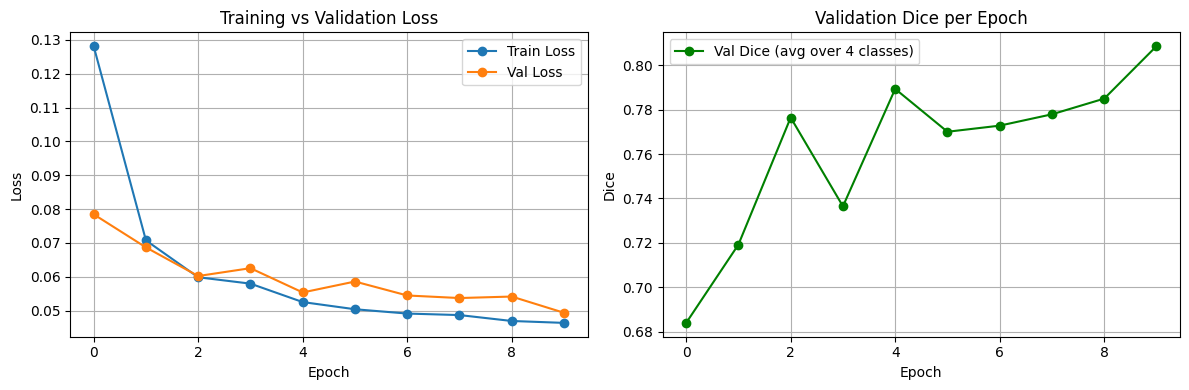

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses,   label='Val Loss',   marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label='Val Dice (avg over 4 classes)', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Validation Dice per Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Metrics and Evaluation

In [13]:
classes = ['Background', 'CSF', 'GM', 'WM']

all_dice = []
all_jacc = []
all_prec = []
all_rec  = []

print("Running final evaluation on validation set...")

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks  = masks.to(device)

        out_dict = model(images)
        main_logits = out_dict["pred"]          # [B, num_classes, H, W]

        preds = torch.argmax(main_logits, dim=1)  # [B, H, W]


        m = calculate_metrics_extended(preds, masks, num_classes=4, ignore_background=False)

        all_dice.append(m['dice'])
        all_jacc.append(m['jaccard'])
        all_prec.append(m['precision'])
        all_rec.append(m['recall'])

import numpy as np

all_dice = np.array(all_dice)
all_jacc = np.array(all_jacc)
all_prec = np.array(all_prec)
all_rec  = np.array(all_rec)

mean_dice = all_dice.mean(axis=0)
mean_jacc = all_jacc.mean(axis=0)
mean_prec = all_prec.mean(axis=0)
mean_rec  = all_rec.mean(axis=0)

print("\nFINAL VALIDATION METRICS (averaged over ALL patches)")
print(f"{'Class':<12} | {'Dice':<8} | {'Jaccard':<8} | {'Precision':<9} | {'Recall':<8}")
print("-"*70)
for i, cls in enumerate(classes):
    print(f"{cls:<12} | {mean_dice[i]:6.4f} | {mean_jacc[i]:6.4f} | "
          f"{mean_prec[i]:6.4f} | {mean_rec[i]:6.4f}")
print("-"*70)

print("\nREQUIRED THRESHOLDS (per assignment):")
print("  WM Dice ≥ 0.70")
print("  GM Dice ≥ 0.73")
print("  CSF Dice ≥ 0.55\n")

# Indices: 0=BG, 1=CSF, 2=GM, 3=WM
wm_ok  = mean_dice[3] >= 0.70   # WM
gm_ok  = mean_dice[2] >= 0.73   # GM
csf_ok = mean_dice[1] >= 0.55   # CSF

print(f"WM Dice = {mean_dice[3]:.4f} --> {'OK' if wm_ok else 'FAIL'}")
print(f"GM Dice = {mean_dice[2]:.4f} --> {'OK' if gm_ok else 'FAIL'}")
print(f"CSF Dice = {mean_dice[1]:.4f} --> {'OK' if csf_ok else 'FAIL'}")


Running final evaluation on validation set...

FINAL VALIDATION METRICS (averaged over ALL patches)
Class        | Dice     | Jaccard  | Precision | Recall  
----------------------------------------------------------------------
Background   | 0.9995 | 0.9989 | 0.9989 | 1.0000
CSF          | 0.7349 | 0.6205 | 0.8442 | 0.6841
GM           | 0.8954 | 0.8261 | 0.8997 | 0.9064
WM           | 0.7952 | 0.7067 | 0.8098 | 0.8398
----------------------------------------------------------------------

REQUIRED THRESHOLDS (per assignment):
  WM Dice ≥ 0.70
  GM Dice ≥ 0.73
  CSF Dice ≥ 0.55

WM Dice = 0.7952 --> OK
GM Dice = 0.8954 --> OK
CSF Dice = 0.7349 --> OK


## Final Visualization

Visualizing subject: IBSR_15_ana_strip.nii.gz


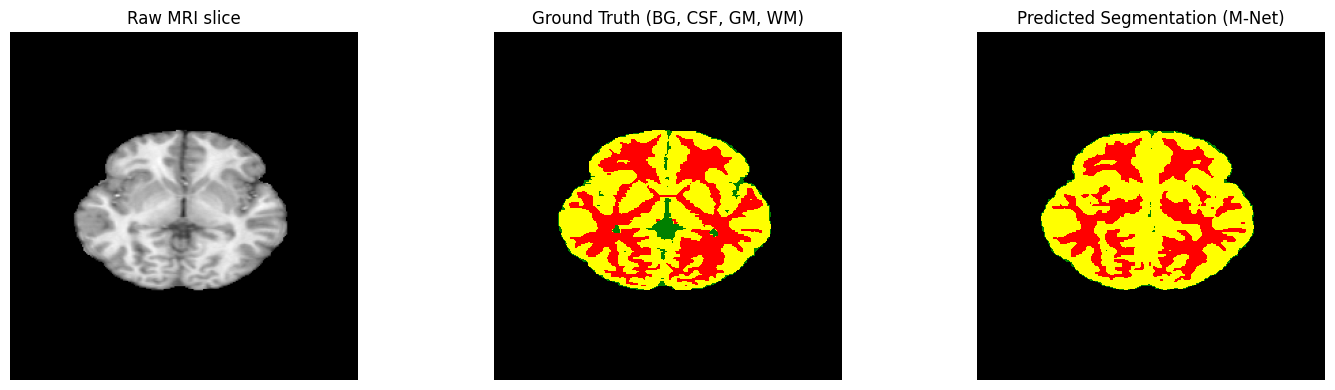

In [14]:
from matplotlib.colors import ListedColormap

tissue_cmap = ListedColormap(['black', 'green', 'yellow', 'red'])

def infer_full_slice(model, vol_data, seg_data, axis, slice_idx,
                     patch_size=128, target_dims=(256, 256)):
    """
    Reconstruct prediction for a full 256x256 slice by tiling the 4 patches.[file:1]
    Uses only the main output of M-Net for inference.
    """
    model.eval()
    with torch.no_grad():
        vol_slice_rot, seg_slice_rot = get_slice_data(vol_data, seg_data, axis, slice_idx)
        vol_padded, seg_padded = pad_slice(vol_slice_rot, seg_slice_rot, target_dims)

        pred_full = np.zeros_like(seg_padded, dtype=np.int64)

        for x in [0, patch_size]:
            for y in [0, patch_size]:
                vol_patch = vol_padded[x:x+patch_size, y:y+patch_size]

                vol_tensor = torch.tensor(
                    vol_patch, dtype=torch.float32
                ).unsqueeze(0).unsqueeze(0).to(device)

                out_dict = model(vol_tensor)
                main_logits = out_dict["pred"]  # [1, num_classes, 128, 128]

                pred_patch = torch.argmax(main_logits, dim=1).squeeze(0).cpu().numpy()
                pred_full[x:x+patch_size, y:y+patch_size] = pred_patch

    return vol_padded, seg_padded, pred_full


# ---- Choose one random validation subject and one plane/slice ----
import random

val_idx = random.randint(0, len(val_vol_files) - 1)
vol_path = val_vol_files[val_idx]
seg_path = val_seg_files[val_idx]
print("Visualizing subject:", os.path.basename(vol_path))

vol_img = nib.load(vol_path)
seg_img = nib.load(seg_path)
vol_data = np.squeeze(vol_img.get_fdata())
seg_data = np.squeeze(seg_img.get_fdata())

axis = 2               # 2=axial, 1=coronal, 0=sagittal[file:1]
slice_idx = vol_data.shape[axis] // 2  # central slice

vol_padded, seg_padded, pred_full = infer_full_slice(
    model, vol_data, seg_data, axis, slice_idx
)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(vol_padded, cmap='gray')
plt.title('Raw MRI slice')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(seg_padded, cmap=tissue_cmap, vmin=0, vmax=3)
plt.title('Ground Truth (BG, CSF, GM, WM)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_full, cmap=tissue_cmap, vmin=0, vmax=3)
plt.title('Predicted Segmentation (M-Net)')
plt.axis('off')

plt.tight_layout()
plt.show()


# Bonus

Initializing M-Net with LeCun method...
Starting training with LeCun Initialization for 10 epochs...
[LeCun Init] Epoch [1/10] Train Loss: 0.1383 | Val Loss: 0.0889 | Val Dice: 0.4994
[LeCun Init] Epoch [2/10] Train Loss: 0.0637 | Val Loss: 0.0603 | Val Dice: 0.7863
[LeCun Init] Epoch [3/10] Train Loss: 0.0565 | Val Loss: 0.0606 | Val Dice: 0.7492
[LeCun Init] Epoch [4/10] Train Loss: 0.0530 | Val Loss: 0.0652 | Val Dice: 0.7233
[LeCun Init] Epoch [5/10] Train Loss: 0.0519 | Val Loss: 0.0601 | Val Dice: 0.7636
[LeCun Init] Epoch [6/10] Train Loss: 0.0499 | Val Loss: 0.0533 | Val Dice: 0.7884
[LeCun Init] Epoch [7/10] Train Loss: 0.0493 | Val Loss: 0.0558 | Val Dice: 0.7739
[LeCun Init] Epoch [8/10] Train Loss: 0.0478 | Val Loss: 0.0573 | Val Dice: 0.7937
[LeCun Init] Epoch [9/10] Train Loss: 0.0477 | Val Loss: 0.0536 | Val Dice: 0.7628
[LeCun Init] Epoch [10/10] Train Loss: 0.0461 | Val Loss: 0.0504 | Val Dice: 0.7880


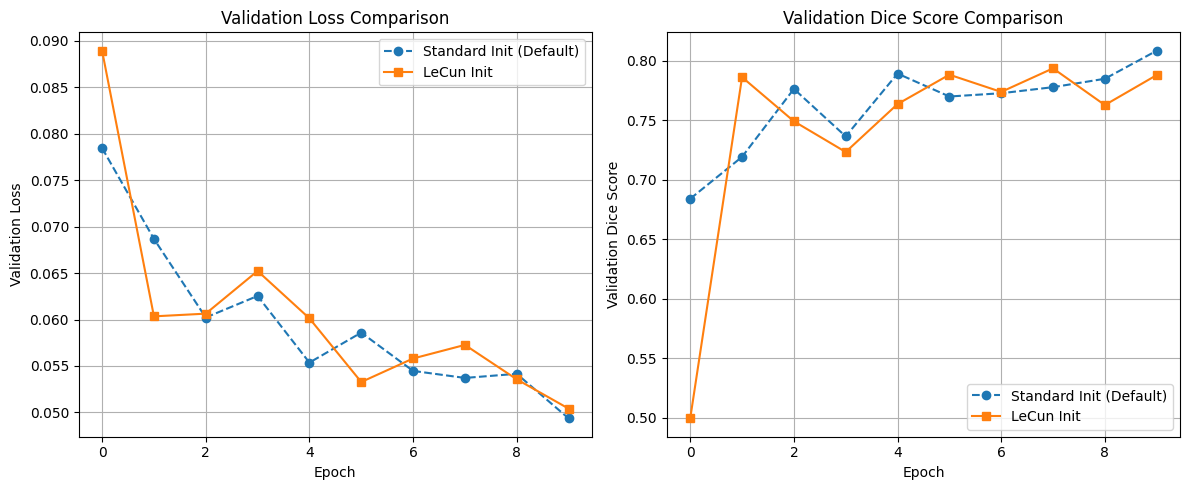

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

def weights_init_lecun(m):
    if isinstance(m, nn.Conv2d):
        # Calculate fan_in using PyTorch's utility
        # fan_in = n * k_h * k_w
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        
        # Calculate standard deviation according to LeCun Normal initialization
        # std = sqrt(1 / fan_in)
        if fan_in != 0:
            std = math.sqrt(1.0 / fan_in)
            
            # Initialize weights with Normal Distribution (mean=0, std=std)
            nn.init.normal_(m.weight, mean=0.0, std=std)
            
            # Initialize bias to zero (if present)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

print("Initializing M-Net with LeCun method...")
model_lecun = MNet(in_channels=1, num_classes=4).to(device)

model_lecun.apply(weights_init_lecun)

optimizer_lecun = optim.SGD(model_lecun.parameters(), lr=LR, momentum=MOMENTUM)
criterion_lecun = nn.CrossEntropyLoss()

lecun_train_losses = []
lecun_val_losses = []
lecun_val_dice_scores = []

print(f"Starting training with LeCun Initialization for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    model_lecun.train()
    running_train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.long().to(device)

        optimizer_lecun.zero_grad()

        out_dict = model_lecun(images)
        main_logits = out_dict["pred"]

        loss = criterion_lecun(main_logits, masks)
        loss.backward()
        optimizer_lecun.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    lecun_train_losses.append(avg_train_loss)

    # ---------- VALIDATION ----------
    model_lecun.eval()
    running_val_loss = 0.0
    epoch_dice = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.long().to(device)

            out_dict = model_lecun(images)
            main_logits = out_dict["pred"]

            val_loss = criterion_lecun(main_logits, masks)
            running_val_loss += val_loss.item()

            preds = torch.argmax(main_logits, dim=1)

            # Calculate Dice (ignoring background)
            batch_metrics = calculate_metrics_extended(
                preds, masks, num_classes=4, ignore_background=True
            )
            
            if batch_metrics['dice']:
                epoch_dice.append(np.mean(batch_metrics['dice']))
            else:
                epoch_dice.append(0.0)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_dice = float(np.mean(epoch_dice)) if epoch_dice else 0.0
    
    lecun_val_losses.append(avg_val_loss)
    lecun_val_dice_scores.append(avg_val_dice)

    print(f"[LeCun Init] Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Dice: {avg_val_dice:.4f}")

# --- 5. Compare Results Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Validation Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Standard Init (Default)', marker='o', linestyle='--')
plt.plot(lecun_val_losses, label='LeCun Init', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

# Plot Validation Dice Comparison
plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label='Standard Init (Default)', marker='o', linestyle='--')
plt.plot(lecun_val_dice_scores, label='LeCun Init', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Dice Score')
plt.title('Validation Dice Score Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
